In [79]:
using Pkg
Pkg.add(["CSV", "DataFrames", "StatsPlots", "Statistics", "MLJ"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [80]:
using CSV, DataFrames, StatsPlots, Statistics, MLJ

## Read data

In [205]:
data = CSV.File("data/train.csv") |> DataFrame;

## Study data format and distribution

In [206]:
print(data[1:3, :])

3×12 DataFrame
 Row │ PassengerId  Survived  Pclass  Name                               Sex     Age       SibSp  Parch  Ticket            Fare     Cabin    Embarked 
     │ Int64        Int64     Int64   String                             String  Float64?  Int64  Int64  String            Float64  String?  String?  
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │           1         0       3  Braund, Mr. Owen Harris            male        22.0      1      0  A/5 21171          7.25    missing  S
   2 │           2         1       1  Cumings, Mrs. John Bradley (Flor…  female      38.0      1      0  PC 17599          71.2833  C85      C
   3 │           3         1       3  Heikkinen, Miss. Laina             female      26.0      0      0  STON/O2. 3101282   7.925   missing  S

In [207]:
describe(data)

,variable,mean,min,median,max
,Symbol,Union…,Any,Union…,Any
1,PassengerId,446.0,1,446.0,891
2,Survived,0.383838,0,0.0,1
3,Pclass,2.30864,1,3.0,3
4,Name,,"Abbing, Mr. Anthony",,"van Melkebeke, Mr. Philemon"
5,Sex,,female,,male
6,Age,29.6991,0.42,28.0,80.0
7,SibSp,0.523008,0,0.0,8
8,Parch,0.381594,0,0.0,6
9,Ticket,,110152,,WE/P 5735


In [208]:
schema(data)

┌─────────────┬─────────────────────────┬────────────────────────────┐
│ _.names     │ _.types                 │ _.scitypes                 │
├─────────────┼─────────────────────────┼────────────────────────────┤
│ PassengerId │ Int64                   │ Count                      │
│ Survived    │ Int64                   │ Count                      │
│ Pclass      │ Int64                   │ Count                      │
│ Name        │ String                  │ Textual                    │
│ Sex         │ String                  │ Textual                    │
│ Age         │ Union{Missing, Float64} │ Union{Missing, Continuous} │
│ SibSp       │ Int64                   │ Count                      │
│ Parch       │ Int64                   │ Count                      │
│ Ticket      │ String                  │ Textual                    │
│ Fare        │ Float64                 │ Continuous                 │
│ Cabin       │ Union{Missing, String}  │ Union{Missing, Textual}    │
│ Emba

## Study of missing values
As we can see from the above table, our data has missing values for the "Age", "Cabin", and "Embarked" fields.

We must assess the proportion of the missing data in the train set to help us decide how to deal with them.

In [209]:
nmissing_age = 0
missing_age_index = []
# iterate through each row
for index in 1:size(data)[1]
    # check if age is missing
    if ismissing(data[index, :Age])
        nmissing_age += 1
        push!(missing_age_index, index)
    end
end
print(nmissing_age)

177

In [210]:
nsurvived_missing_age = 0
for value in eachrow(data[missing_age_index, :])
    if value.Survived == 1
        nsurvived_missing_age += 1
    end
end
print(nsurvived_missing_age)

52

### A large part of the data has missing values for Age, this can turn out to be problematic for the ML algorithms...
A possible solution would be to drop the "Age" column if there is not a big correlation with target labels.

Another would be to replace missing values with random integers sampled according to the mean and variance of the available data.

In [211]:
nmissing_cabin = 0
for index in 1:size(data)[1]
    # check if cabin is missing
    if ismissing(data[index, :Cabin])
        nmissing_cabin += 1
    end
end
print(nmissing_cabin)

687

### The majority of our data does not have a value for the "Cabin" field.
This doesn't leave much to choose from..

Again, we can simply drop the field.

Or map it to a new "HasCabin" property.

In [212]:
data[:, [:Cabin, :Pclass]]

,Cabin,Pclass
,String?,Int64
1,missing,3
2,C85,1
3,missing,3
4,C123,1
5,missing,3
6,missing,3
7,E46,1
8,missing,3
9,missing,3


### We can notice that it is more common for people in second or third class to have a missing cabin.
Let's study the relation between these two properties

In [213]:
m = zeros(Int64, 3, 2)

for value in eachrow(data)
    if value.Pclass == 1
        if ismissing(value.Cabin)
            m[1, 2] = m[1, 2] + 1
        else
            m[1, 1] = m[1, 1] + 1
        end
    elseif value.Pclass == 2
        if ismissing(value.Cabin)
            m[2, 2] = m[2, 2] + 1
        else
            m[2, 1] = m[2, 1] + 1
        end
    else
        if ismissing(value.Cabin)
            m[3, 2] = m[3, 2] + 1
        else
            m[3, 1] = m[3, 1] + 1
        end
    end
end

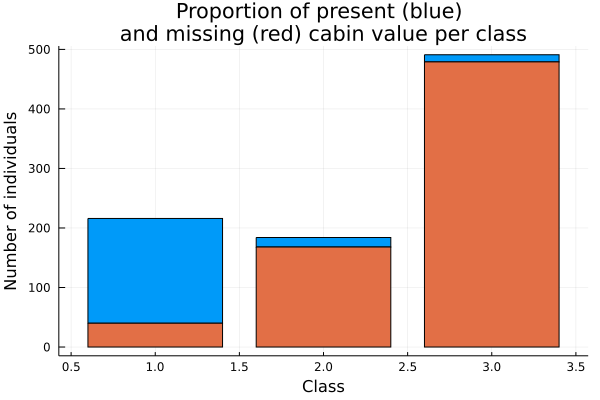

In [214]:
groupedbar(m, bar_position = :stack, 
    title="Proportion of present (blue) \nand missing (red) cabin value per class", 
    xlabel="Class", ylabel="Number of individuals", legend=false)

### It seems that our guess is correct.
Because there is a high correlation between the pressence of a cabin and the class of person, we can choose to discard the "Cabin" property.

In [215]:
select!(data, Not(:Cabin));

### Let's now study the "Embarked" field

In [216]:
nmissing_embarked = 0

for value in eachrow(data)
    if ismissing(value.Embarked)
        nmissing_embarked += 1
    end
end

print(nmissing_embarked)

2

### There are only two values that are missing.
That is great news, it means that we could replace them with the most common port of embarkation without affecting the data distribution *too much*

### In the next steps, we will study the influence of each field on the "Survived" label.
First off, we can discard the PassengerId because it doesn't gives us any insight into anything.

In [217]:
select!(data, Not(:PassengerId));

### Pclass

In [218]:
all_classes = data[:, 3]
classes = unique(all_classes)

first_class = filter(x -> x.Pclass == 1, data)
first_class_survivors = filter(x -> x.Survived == 1, first_class)

second_class = filter(x -> x.Pclass == 2, data)
second_class_survivors = filter(x -> x.Survived == 1, second_class)

third_class = filter(x -> x.Pclass == 3, data)
third_class_survivors = filter(x -> x.Survived == 1, third_class);

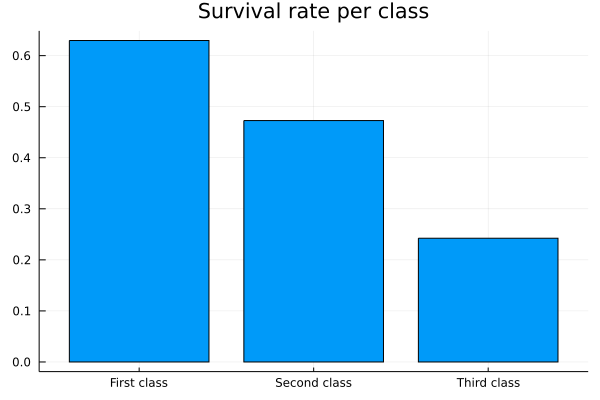

In [219]:
a1 = [nrow(first_class_survivors) / nrow(first_class),
        nrow(second_class_survivors) / nrow(second_class),
        nrow(third_class_survivors) / nrow(third_class)]

bar(["First class", "Second class", "Third class"], a1,
        title="Survival rate per class", legend=false)

In [220]:
cor(data.Survived, data.Pclass)

-0.33848103596101586

Great news, we found our first influencial value. Just by being in the first class, a person has a 60% chance of survival. We can hopefully combine this property with others to more accurately estimate our chances of survival. 

### Sex

In [221]:
m = zeros(Int64, 2, 2)
nam = repeat(["Male", "Female"])

for value in eachrow(data)
    if value.Sex == "male"
        if value.Survived == 1
            m[1, 1] = m[1, 1] +1
        else
            m[1, 2] = m[1, 2] +1
        end
    else
        if value.Survived == 1
            m[2, 1] = m[2, 1] + 1
        else
            m[2, 2] = m[2, 2] + 1
        end
    end
end

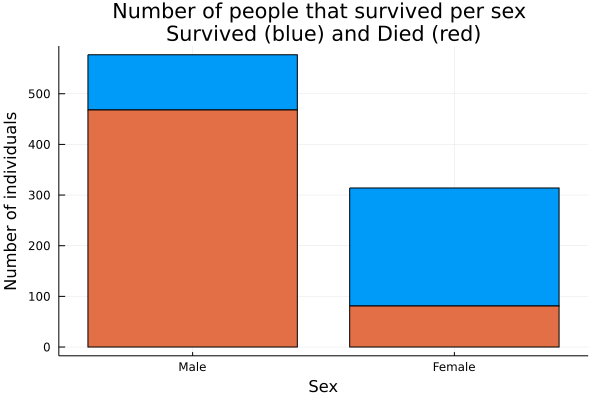

In [222]:
groupedbar(nam, m, bar_position = :stack, 
    title="Number of people that survived per sex \nSurvived (blue) and Died (red)", 
    xlabel="Sex", ylabel="Number of individuals", legend=false)

### It seems that women had a higher change to survive 

In [223]:
all_sexes = data[:, :Sex]
sex = unique(all_sexes)

males = filter(x -> x.Sex == "male", data)
male_survivors = filter(x -> x.Survived == 1, males)

females = filter(x -> x.Sex == "female", data)
female_survivors = filter(x -> x.Survived == 1, females);

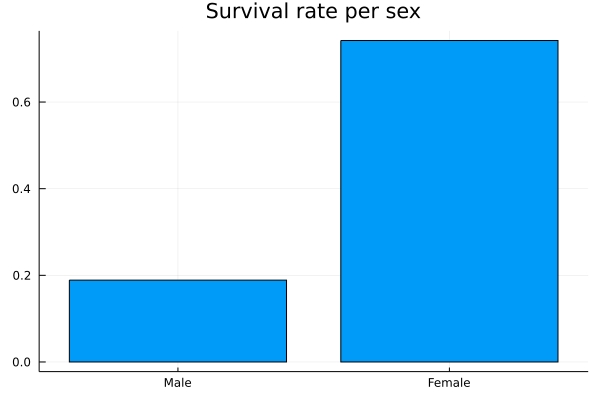

In [224]:
a2 = [nrow(male_survivors) / nrow(males),
    nrow(female_survivors) / nrow(females)]

bar(["Male", "Female"], a2, title="Survival rate per sex", legend=false)

In [225]:
sex = map(x -> x == "male" ? 0 : 1, data.Sex)
cor(data.Survived, sex)

0.5433513806577527

### We found another good indicator for survivability
Could it be that there is some correlation between sex and class?

In [226]:
m = zeros(Int64, 2, 3)
nam = ["Male", "Female"]

for value in eachrow(data)
    if value.Sex == "male"
        m[1, value.Pclass] += 1
    else
        m[2, value.Pclass] +=1
    end
end

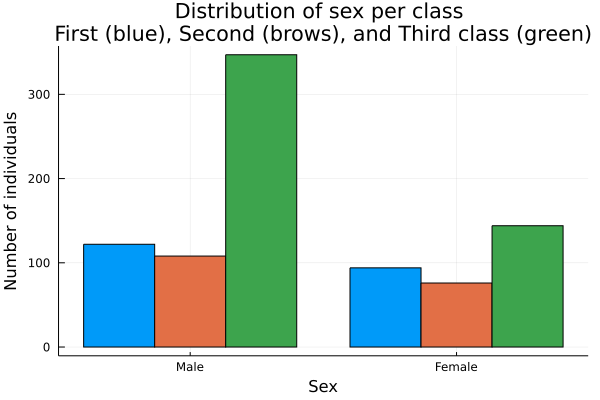

In [227]:
groupedbar(nam, m, bar_position = :dodge, 
    title="Distribution of sex per class \nFirst (blue), Second (brows), and Third class (green)", 
    xlabel="Sex", ylabel="Number of individuals", legend=false)

In [228]:
for sex in unique(data.Sex), class in unique(data.Pclass)
    all_sex = count(x -> x.Sex == sex, eachrow(data))
    all_sex_and_class = count(x -> (x.Sex == sex && x.Pclass == class), eachrow(data))
    perc = all_sex_and_class / all_sex
    println("Percentage of $(sex)s in $(class) class:  $(perc)")
end

Percentage of males in 3 class:  0.6013864818024264
Percentage of males in 1 class:  0.21143847487001732
Percentage of males in 2 class:  0.18717504332755633
Percentage of females in 3 class:  0.4585987261146497
Percentage of females in 1 class:  0.29936305732484075
Percentage of females in 2 class:  0.24203821656050956


In [229]:
cor(sex, data.Pclass)

-0.13190049060473868

### Sex-class differences
There certainly is some difference in the distrubution of sexes for the third class (a 14% increase for males) and a slight increase for females in the first and second classes.

This, however does not explain the high rate of survability for people in the first class, but it does explain the mortality rate for poeple in the third class: there are far more males in that group.

For these reasons, it might be a good idea to keep the Pclass feature to get more accurate estimates.

### Name
It is somewhat hard to extract anything useful from the name field but after some research (source: https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/), there is title present (eg: Mr, Miss, Master etc) in each name. 

We could use this title to infer other information such as sex (Mr/Mrs), age (Master/Miss) or status (Don, Rev, Capt etc).

In [230]:
# function to map name to title eg: mr, miss, master, doctor etc
function substring_in_string(big_string, substrings)
    for substring in substrings
        if occursin(substring, big_string)
            return substring
        end
    end
    return missing
end

titles_list = ["Mrs", "Mr", "Master", "Miss", "Major", "Rev",
                    "Dr", "Ms", "Mlle","Col", "Capt", "Mme", "Countess",
                    "Don", "Jonkheer"];

In [231]:
data.Title = map(x -> substring_in_string(x, titles_list), data.Name);

891-element Vector{String}:
 "Mr"
 "Mrs"
 "Miss"
 "Mrs"
 "Mr"
 "Mr"
 "Mr"
 "Master"
 "Mrs"
 "Mrs"
 "Miss"
 "Miss"
 "Mr"
 ⋮
 "Mrs"
 "Mrs"
 "Mr"
 "Miss"
 "Mr"
 "Mr"
 "Mrs"
 "Rev"
 "Miss"
 "Miss"
 "Mr"
 "Mr"

In [247]:
m = zeros(Int64, size(titles_list)[1], 2)
nam = titles_list

for value in eachrow(data)
    if value.Survived == 0
        m[findfirst(isequal(value.Title), titles_list), 1] += 1
    else
        m[findfirst(isequal(value.Title), titles_list), 2] += 1
    end
end

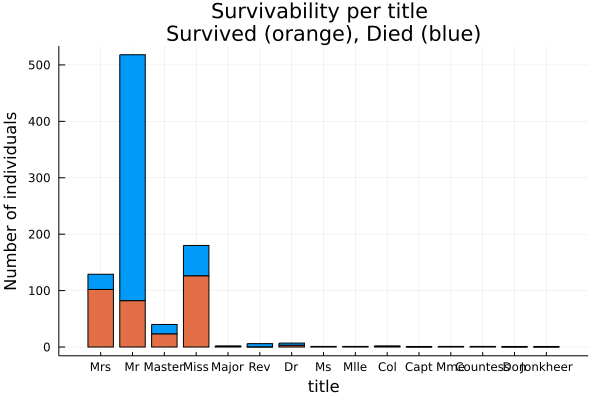

In [251]:
groupedbar(nam, m, bar_position = :stack, 
    title="Survivability per title \nSurvived (orange), Died (blue)", 
    xlabel="title", ylabel="Number of individuals", legend=false)

In [258]:
for title in titles_list
    all_with_title = filter(x -> x.Title == title, eachrow(data))
    nwith_title_survived = count(x -> x.Survived == 1, all_with_title)
    perc = nwith_title_survived / size(all_with_title)[1]
    println("Survival rate for $(title): $perc")
end

Survival rate for Mrs: 0.7906976744186046
Survival rate for Mr: 0.1583011583011583
Survival rate for Master: 0.575
Survival rate for Miss: 0.7
Survival rate for Major: 0.5
Survival rate for Rev: 0.0
Survival rate for Dr: 0.42857142857142855
Survival rate for Ms: 1.0
Survival rate for Mlle: 1.0
Survival rate for Col: 0.5
Survival rate for Capt: 0.0
Survival rate for Mme: 1.0
Survival rate for Countess: 1.0
Survival rate for Don: 0.0
Survival rate for Jonkheer: 0.0


In [286]:
count(x -> x.Title == "Dr", eachrow(data))

7

### Title-survival conclusion
As expected, titles that correspond to members of the fair sex have a higher chance to survive.

On the other hand, people that have the title "Master" (with 40 examples) has a disproportionatly high chance of survival for their sex.

The other titles are too scarce (1 to 7 occurrences) to allow us to draw any meaningful conclusions.

In [289]:
titles = map(x -> findfirst(isequal(x.Title), titles_list), eachrow(data))
cor(data.Survived, titles)

0.11630251551624159

In [290]:
cor(sex, titles)

0.20118535640891191

### There is some correlation between title and survability
but we can safely blame it on its relation to sex.

For training the classification algorithms, we could easily choose to ignore the "Title" and "Name" properties but taking into consideration the "Master" title could prove to be handy. 

In [102]:
n = count(map(x -> x.Sex == "female", eachrow(data)))

314

In [265]:
@doc Plots

No documentation found.

No docstring found for module `Plots`.


In [6]:
y = data.Survived

891-element Vector{Int64}:
 0
 1
 1
 1
 0
 0
 0
 0
 1
 1
 1
 1
 0
 ⋮
 1
 1
 0
 0
 0
 0
 0
 0
 1
 0
 1
 0